In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

from torchvision.models import vgg16_bn

In [2]:
path = Path('data')
path_hr = path/'photo'
path_lr = path/'crappy'

In [3]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

In [4]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [5]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(resize_method=ResizeMethod.SQUISH, size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [6]:
data_gen = get_data(bs,size)

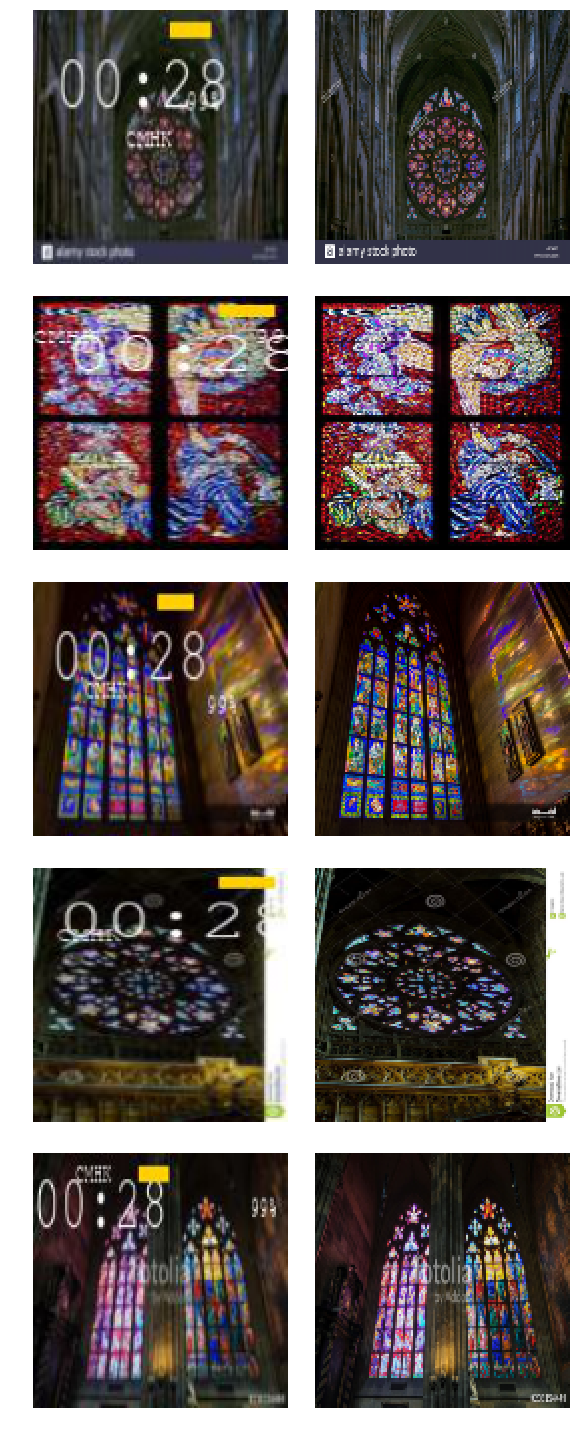

In [7]:
data_gen.show_batch()

In [12]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()

def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [9]:
learn_gen = create_gen_learner()

In [10]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [11]:
learn_gen.unfreeze()

In [12]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

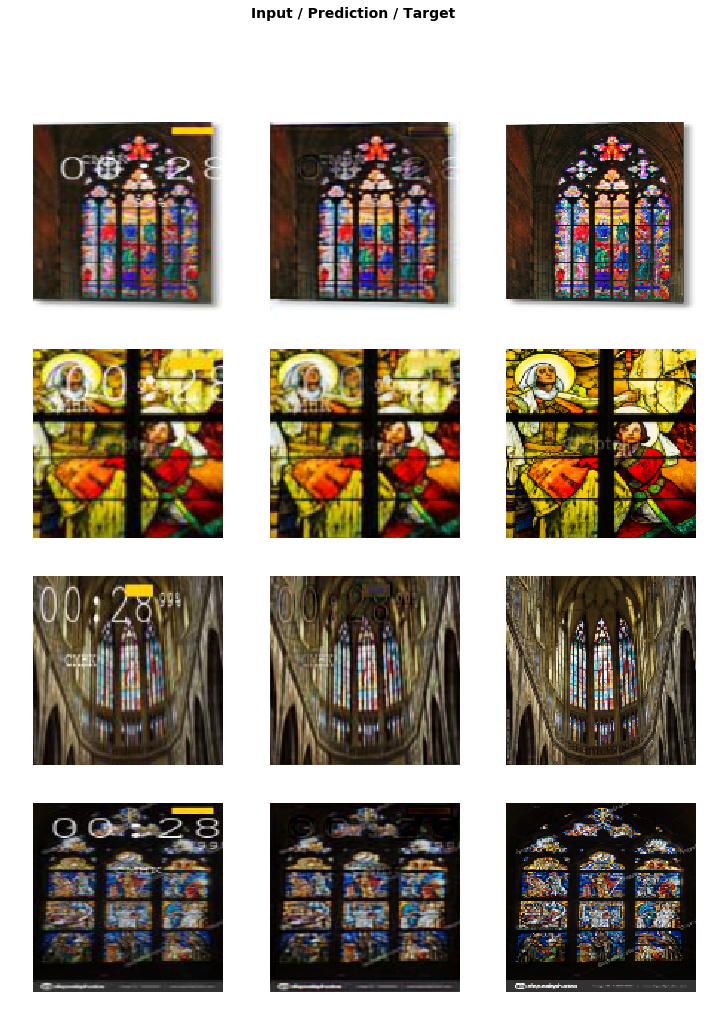

In [13]:
learn_gen.show_results(rows=4)

In [14]:
learn_gen.save('gen-pre2')

# Save generated images

In [15]:
learn_gen.load('gen-pre2');

In [16]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [17]:
path_gen.mkdir(exist_ok=True)

In [18]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [19]:
save_preds(data_gen.fix_dl)

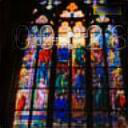

In [20]:
PIL.Image.open(path_gen.ls()[0])

# Train critic

In [21]:
learn_gen=None
gc.collect()

42

In [8]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(resize_method=ResizeMethod.SQUISH, size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [10]:
data_crit = get_crit_data([name_gen, 'photo'], bs=bs, size=size)
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

NameError: name 'name_gen' is not defined

In [9]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [25]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)
learn_critic.fit_one_cycle(6, 1e-3)

In [26]:
learn_critic.save('critic-pre2')

# GAN
Now we'll combine those pretrained model in a GAN.

In [11]:
learn_crit=None
learn_gen=None
gc.collect()

19859

In [10]:
bs, size = 8, 128

In [13]:
data_crit = get_crit_data(['crappy', 'photo'], bs=bs, size=size)
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects for the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by learn_crit.loss_func. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0).

The loss of the generator is weighted sum (weights in weights_gen) of learn_crit.loss_func on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the learn_gen.loss_func applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [14]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [15]:
lr = 1e-4
learn.fit(40,lr)

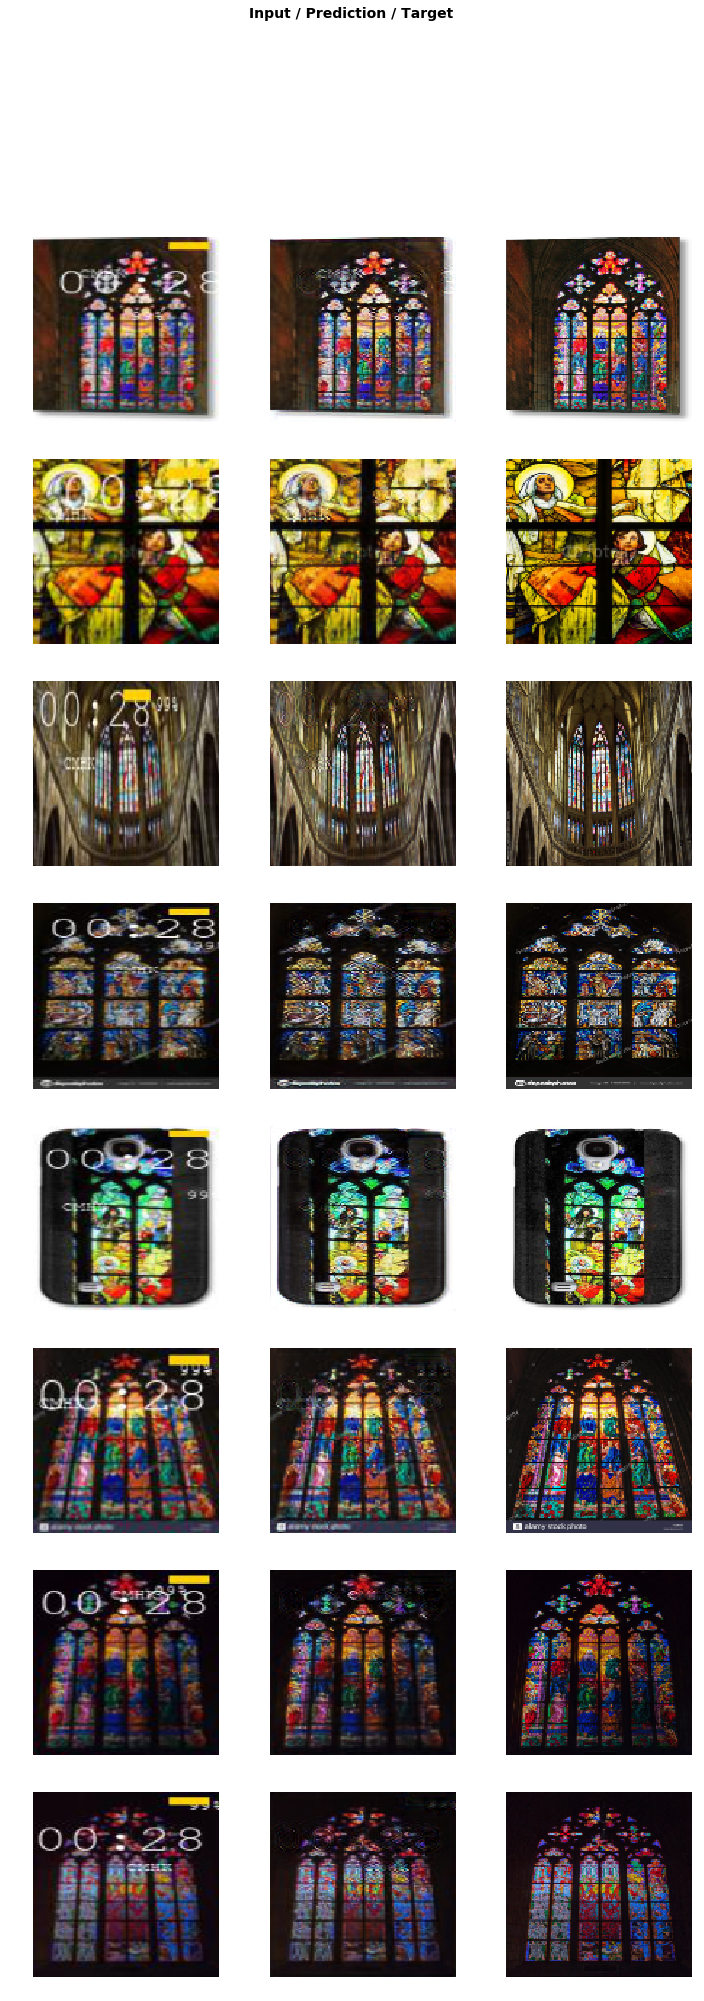

In [16]:
learn.show_results(rows=16)

In [17]:
learn.save('gan-1c')

In [18]:
learn.data=get_data(6,192)
learn.fit(10,lr/2)

In [19]:
learn.save('gan-1d')

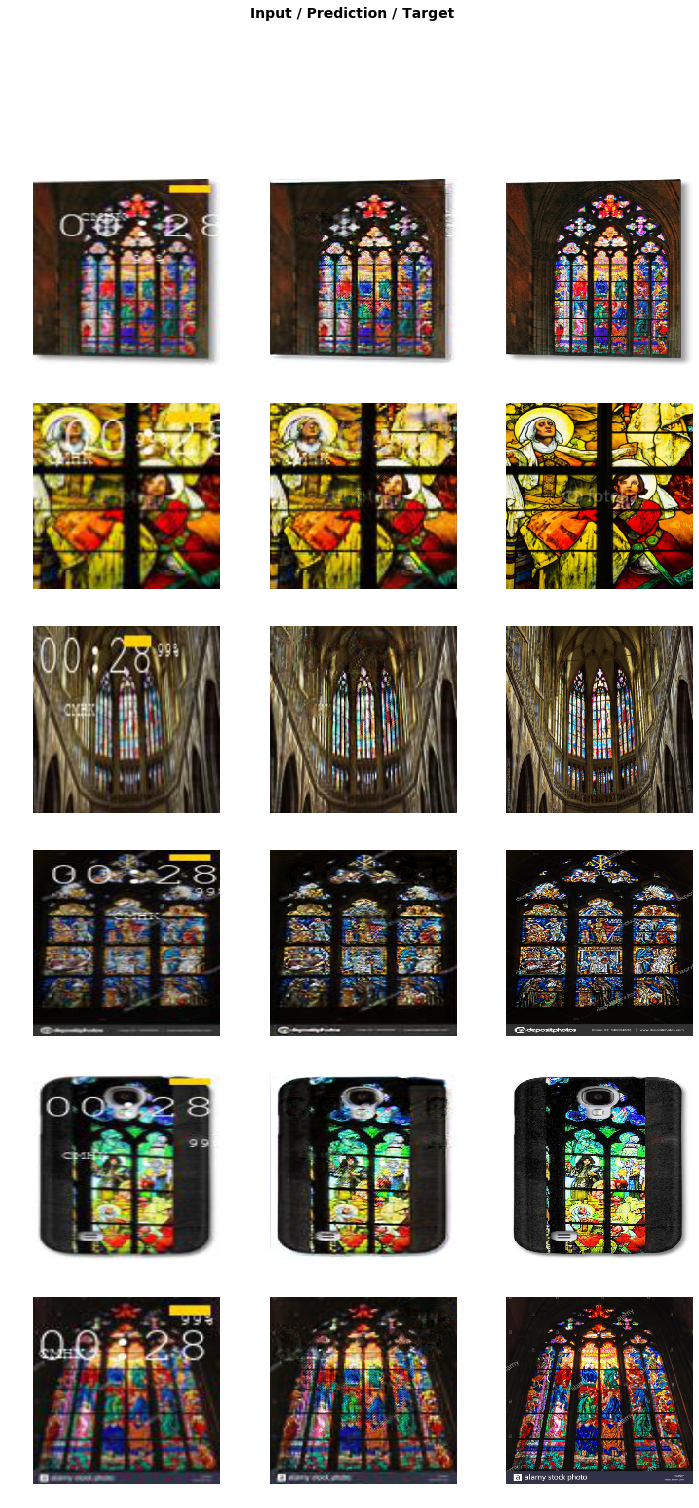

In [20]:
learn.show_results(rows=16)

In [21]:
learn_gen.save('gen-1d')

In [42]:
learn.data=get_data(3,256)
learn.fit(10,lr/2)

In [43]:
learn.save('gan-1e')

In [15]:
learn.load('gan-1e', purge=False)

GANLearner(data=ImageDataBunch;

Train: LabelList (526 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data/crappy;

Valid: LabelList (58 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data/crappy;

Test: None, model=GANModule(
  (generator): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    

In [16]:
def get_test_data(bs):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(resize_method=ResizeMethod.SQUISH, size=(1000), tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [17]:
learn.data = get_test_data(1)

In [18]:
img = open_image('testing.jpg'); img.shape
p,img_hr,b = learn_gen.predict(img)

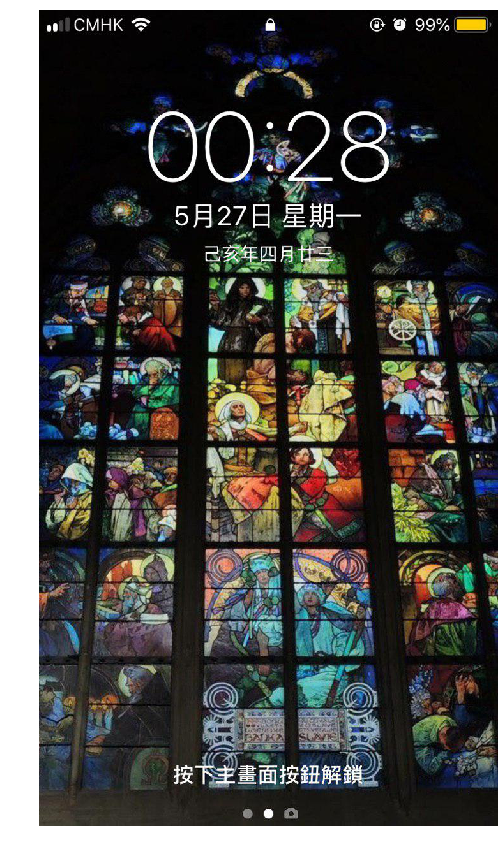

In [19]:
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


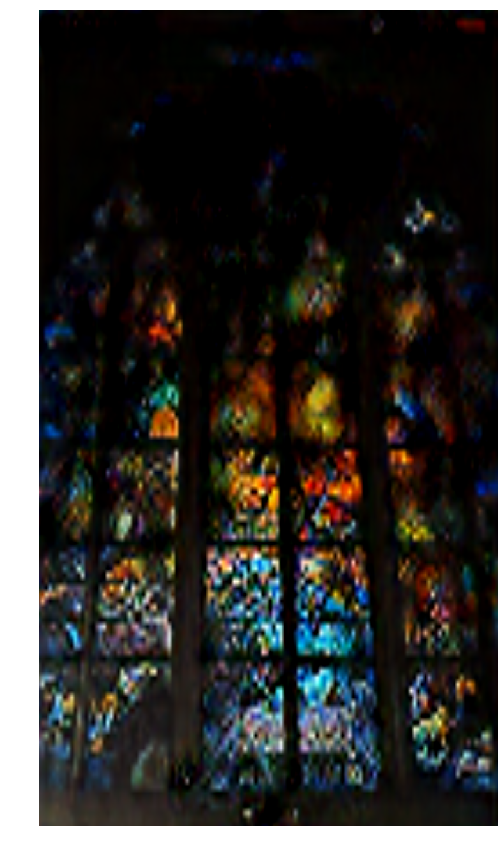

In [20]:
show_image(Image(img_hr).resize((3, 1280, 719)), figsize=(18,15), interpolation='nearest')